<a href="https://colab.research.google.com/github/Yug-Oswal/Custom-DistributedTraining-TF/blob/main/ObjectLocalization(FromScratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

AUTO = tf.data.AUTOTUNE

In [18]:
train_data, train_info = tfds.load("mnist", split="train", as_supervised=True, with_info=True)
valid_data = tfds.load("mnist", split="test", as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [20]:
ds = train_data.take(10)
tfds.as_dataframe(ds, train_info)

,image,label
0,,4
1,,1
2,,0
3,,7
4,,8
5,,1
6,,2
7,,7
8,,1
9,,6


In [31]:
def transform_image(image, label):
  x_min = tf.random.uniform((), 0, 48, dtype=tf.int64)
  y_min = tf.random.uniform((), 0, 48, dtype=tf.int64)
  image = tf.image.pad_to_bounding_box(image, y_min, x_min, 75, 75)
  image = tf.cast(image, dtype=tf.float32)
  x_min = tf.cast(x_min, dtype=tf.float32)
  y_min = tf.cast(y_min, dtype=tf.float32)
  image /= 255.
  x_max = (x_min + 28) / 75
  y_max = (y_min + 28) / 75
  x_min /= 75
  y_min /= 75

  return image, (tf.one_hot(label, 10), [x_min, y_min, x_max, y_max])

In [32]:
BATCH_SIZE = 32

In [33]:
def transform_train_test_data(train_data, test_data):
  train_data = train_data.map(transform_image, num_parallel_calls=AUTO)
  train_data = train_data.shuffle(10000, reshuffle_each_iteration=True)
  train_data = train_data.repeat()
  train_data = train_data.batch(batch_size=BATCH_SIZE, drop_remainder=True)
  train_dataset = train_data.prefetch(-1)

  test_data = test_data.map(transform_image, num_parallel_calls=AUTO)
  test_data = test_data.repeat()
  test_dataset = test_data.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(-1)

  return train_dataset, test_dataset

In [34]:
training_dataset, validation_dataset = transform_train_test_data(train_data, valid_data)

In [100]:
def display_images(dataset, num):
  count = 0
  ds = dataset.take(1)
  for batch in ds:
    digits = batch[0].numpy()
    labels = batch[1][0].numpy()
    bboxes = batch[1][1].numpy()
    for digit, label, bbox in zip(digits, labels, bboxes):
      if count >= num:
        break
      count += 1
      draw_bounding_boxes(digit, label, bbox)


def draw_bounding_boxes(digit, label, bbox):
  xmin = bbox[0]
  ymin = bbox[1]
  xmax = bbox[2]
  ymax = bbox[3]
  image_array = digit * 255.
  image_array = image_array.reshape((75, 75))
  image = Image.fromarray(image_array)
  im_width, im_height = image.size
  draw = ImageDraw.Draw(image)

  (left, top, right, bottom) = (xmin * im_width,
                                ymin * im_height,
                                xmax * im_width,
                                ymax * im_height)
  draw.line([(left, bottom), (right, bottom), (right, top), (left, top), (left, bottom)],
            fill="red")
  plt.imshow(image)
  plt.xlabel(np.argmax(label))

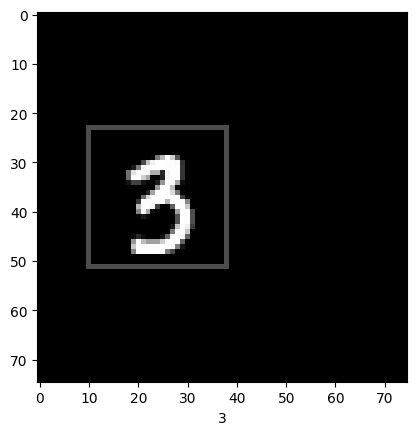

In [101]:
display_images(training_dataset, 1)